# Spiral extraction methodology

1. Obtain Sérsic parameters of galaxy from NSA catalog
2. Translate the Sérsic $\phi$ into zooniverse image coordinates
    - Need to re-create the transforms used to generate the image for volunteers (due to poor decision making in the subject creation process)
2. Cluster drawn poly-lines
    1. Deproject drawn arms
    2. Cluster using DBSCAN and a custom metric
    3. Use Local Outlier Factor to clean points
    5. Sort points in cluster
    6. Fit a smoothing spline to ordered points
3. Calculate pitch angles for the resulting spline fits

First, say the jupyter magic words 🧙‍

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import the plethora of useful modules we'll need (including some we probably don't)

In [2]:
import os
from tempfile import NamedTemporaryFile
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from PIL import Image
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import rotate, rescale
import astropy.units as u
from gzbuilderspirals import deprojecting as dpj
from gzbuilderspirals import getDrawnArms, deprojectArm, rThetaFromXY, xyFromRTheta
from gzbuilderspirals.galaxySpirals import GalaxySpirals
import sdssCutoutGrab as scg
import createSubjectsFunctions as csf

Open the NSA catalog, and the galaxy builder subjects and classifications

In [3]:
nsa = fits.open('../../subjectUpload/nsa_v1_0_1.fits')

In [4]:
nsa_keys = [
    'NSAID', 'ISDSS', 'INED', 'RA', 'DEC', 'Z', 'SERSIC_BA', 'SERSIC_PHI', 'PETRO_THETA', 
    'IAUNAME', 'ZDIST', 'RUN', 'CAMCOL', 'FIELD', 'RERUN',
]
nsaRas = nsa[1].data['ra']
nsaDecs = nsa[1].data['dec']

df_nsa = pd.DataFrame(
    {key: nsa[1].data[key].byteswap().newbyteorder() for key in nsa_keys}
)

In [5]:
classifications = pd.read_csv('../classifications/galaxy-builder-classifications_24-7-18.csv')
subjects = pd.read_csv('../classifications/galaxy-builder-subjects_24-7-18.csv')
null = None
true = True
false = False

Define the subject ID we want to use. This is parametrised using papermill to allow batch running.

In [6]:
subjectId = 21096790

Grab the metadata of the subject we are working on

In [7]:
meta = eval(subjects[subjects['subject_id'] == subjectId].iloc[0]['metadata'])

And the NSA data for the galaxy (if it's a galaxy with NSA data, otherwise throw an error)

In [8]:
try:
    gal = df_nsa[df_nsa['NSAID'] == int(meta['NSA id'])]
except KeyError:
    gal = {}
    raise KeyError('Metadata does not contain valid NSA id (probably an older galaxy)')
    
gal

,CAMCOL,DEC,FIELD,IAUNAME,INED,ISDSS,NSAID,PETRO_THETA,RA,RERUN,RUN,SERSIC_BA,SERSIC_PHI,Z,ZDIST
412706,1,20.248024,217,J083054.12+201452.9,56991,441859,436500,24.948637,127.725538,301,6597,0.821469,147.206299,0.021098,0.020987


Now we need to obtain the galaxy's rotation in Zooniverse image coordinates. This is made trickier by some decision in the subject creation pipeline.

First, use a WCS object to obtain the rotation in pixel coordinates, as would be obtained from `fitsFile[0].data`

In [9]:
fitsname = dpj.getFitsName(gal)
print(fitsname)

fitsImages/6597/1/frame-r-006597-1-0217.fits


In [10]:
w = dpj.createWCSObject(gal, 512)
angle = dpj.getAngle(gal, w, np.array([512, 512]))
print('angle:', angle)

angle: 101.57840740869189


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


We'll now download the Zooniverse image that volunteers actually classified on

In [11]:
url = 'https://panoptes-uploads.zooniverse.org/production/subject_location/6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10.png'
print('URL of galaxy image:')
print(url)
imgData = requests.get(url).content

f = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
f.write(imgData)
f.close()
pic = Image.open(f.name)
os.unlink(f.name)

URL of galaxy image:
https://panoptes-uploads.zooniverse.org/production/subject_location/6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10.png


Next, re-create an image (including masking and cutouts) from the FITS file

In [12]:
fitsImageTmp = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
fitsFile = fits.open(fitsname)

r = float(gal['PETRO_THETA'])/3600
imageData = scg.cutFits(
    fitsFile,
    float(gal['RA']), float(gal['DEC']),
    size=(4 * r * u.degree, 4 * r * u.degree)
)

objects, segmentation_map = csf.sourceExtractImage(
    imageData,
    fitsFile[2].data[0][0]
)

# create a true/false masking array
mask = csf.maskArr(imageData, segmentation_map, objects[-1][0] + 1)

# create the masked image
maskedImageData = imageData[:]
maskedImageData[mask] = 0

# apply an asinh stretch
stretchedImageData = csf.stretchArray(maskedImageData[:, ::-1])

resizeTo = (512, 512)

im = csf.saveImage(
    stretchedImageData,
    fname=fitsImageTmp.name,
    resize=True,
    size=resizeTo
)
fitsImageTmp.close()
pic = Image.open(fitsImageTmp.name)
os.unlink(fitsImageTmp.name)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Sorting extracted objects by radius from center
📷  Saving image to /var/folders/z2/y1lrc76x3tg_jc0ftm6tshr40000gn/T/tmpewh3e_0d.png


Grab the data arrays from the Image objects, and imshow the images (for debugging purposes)

In [144]:
picArray = np.array(pic)
imArray = np.array(im)

Trial some image transformations to see what needs to be done to get the angle in Zoo coordinates

In [14]:
transforms = ['Nothing', 'Transpose', 'Transpose and mirror y']
d1 = gaussian_filter(picArray - imArray, 10)
d2 = gaussian_filter(picArray.T - imArray, 10)
d3 = gaussian_filter(picArray.T[:, ::-1] - imArray, 10)
best = np.argmin(list(map(np.sum, map(np.abs, (d1, d2, d3)))))
print('Best transformation:', transforms[best])


Best transformation: Nothing


Using this knowledge, transform the angle to (hopefully) work in our Zooniverse image frame

In [15]:
if best == 1:
    angle = 90 - angle
if best == 2:
    angle = angle - 90
    
print('angle: {}'.format(angle))

angle: 101.57840740869189


Now deproject the image of the galaxy:

/Users/tlingard/anaconda/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(-0.5, 512.5, -0.5, 511.5)

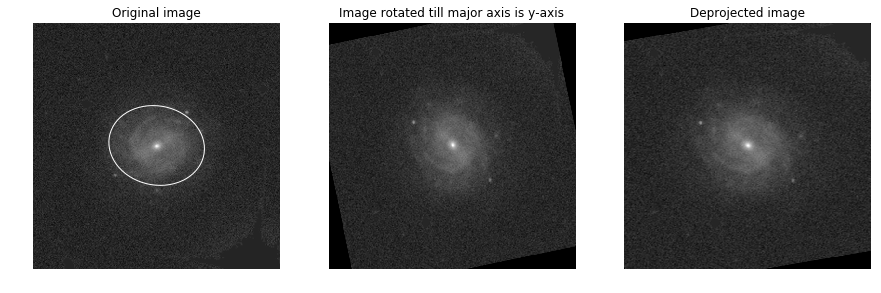

In [16]:
rotatedImage = rotate(picArray, -angle)
rotatedImage.shape
stretchedImage = rescale(rotatedImage, (1, 1/gal['SERSIC_BA'].iloc[0]))

n = int((stretchedImage.shape[1] - np.array(pic).shape[1]) / 2)

if n > 0: deprojectedImage = stretchedImage[:, n:-n]
else: deprojectedImage = stretchedImage.copy()

plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.title('Original image')
plt.imshow(picArray, origin='lower', cmap='gray')
ax = plt.gca()
e = Ellipse(
    xy=np.array(picArray.shape) / 2,
    width=200 * gal['SERSIC_BA'],
    height=200,
    angle=-angle,
    ec='w',
    fc='none'
)
ax.add_artist(e)
plt.axis('off')
plt.subplot(132)
plt.title('Image rotated till major axis is y-axis')
plt.imshow(rotatedImage, origin='lower', cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.title('Deprojected image')
plt.imshow(deprojectedImage, origin='lower', cmap='gray')
plt.axis('off')

In [17]:
# sizes = [gal['PETRO_THETA'].iloc[0] * gal['SERSIC_BA'].iloc[0], gal['PETRO_THETA'].iloc[0]]
# tpl = '''global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
# fk5
# ellipse({RA},{DEC},{}",{}",{SERSIC_PHI})'''.format(*sizes, **gal.iloc[0])

# with open('template-ds9.reg', 'w') as f:
#     f.write(tpl)
# print('ds9 {} -regions {}'.format(fitsname, './template-ds9.reg'))

ds9 fitsImages/6597/1/frame-r-006597-1-0217.fits -regions ./template-ds9.reg


## Onto the clustering and fitting

Extract the drawn arms from classifications for this galaxy

In [18]:
drawnArms = getDrawnArms(subjectId, classifications)
print('Found {} arms'.format(len(drawnArms)))

Found 40 arms


We'll make use of the `gzbuilderspirals` class method to cluster arms.

First, initialise a `GalaxySpirals` object with the arms and deprojection parameters

In [122]:
s = GalaxySpirals(drawnArms, ba=gal['SERSIC_BA'].iloc[0], phi=angle)

Now calculate a the distance matrix for the drawn arms (this can be slow)

In [98]:
distances = s.calculateDistances()

Perform the clustering (using the DBSCAN clustering algorithm)

In [123]:
db = s.clusterLines(distances)

Fit both XY and radial splines to the resulting clusters (described in more detail in the method paper)

In [140]:
xyFits = s.fitXYSplines()
result = s.fitRadialSplines(xyFits)

Add a helper function to generate plots of the resulting arms

In [24]:
def prettyPlot(arm, **kwargs):
    plt.plot(
        *arm.T,
        c='k'.format(i), linewidth=4
    )
    plt.plot(
        *arm.T, linewidth=3, **kwargs
    )
    plt.plot(
        *arm.T,
        c='w', linewidth=2, alpha=0.5
    )

Plot the calculated arms before and after deprojection:

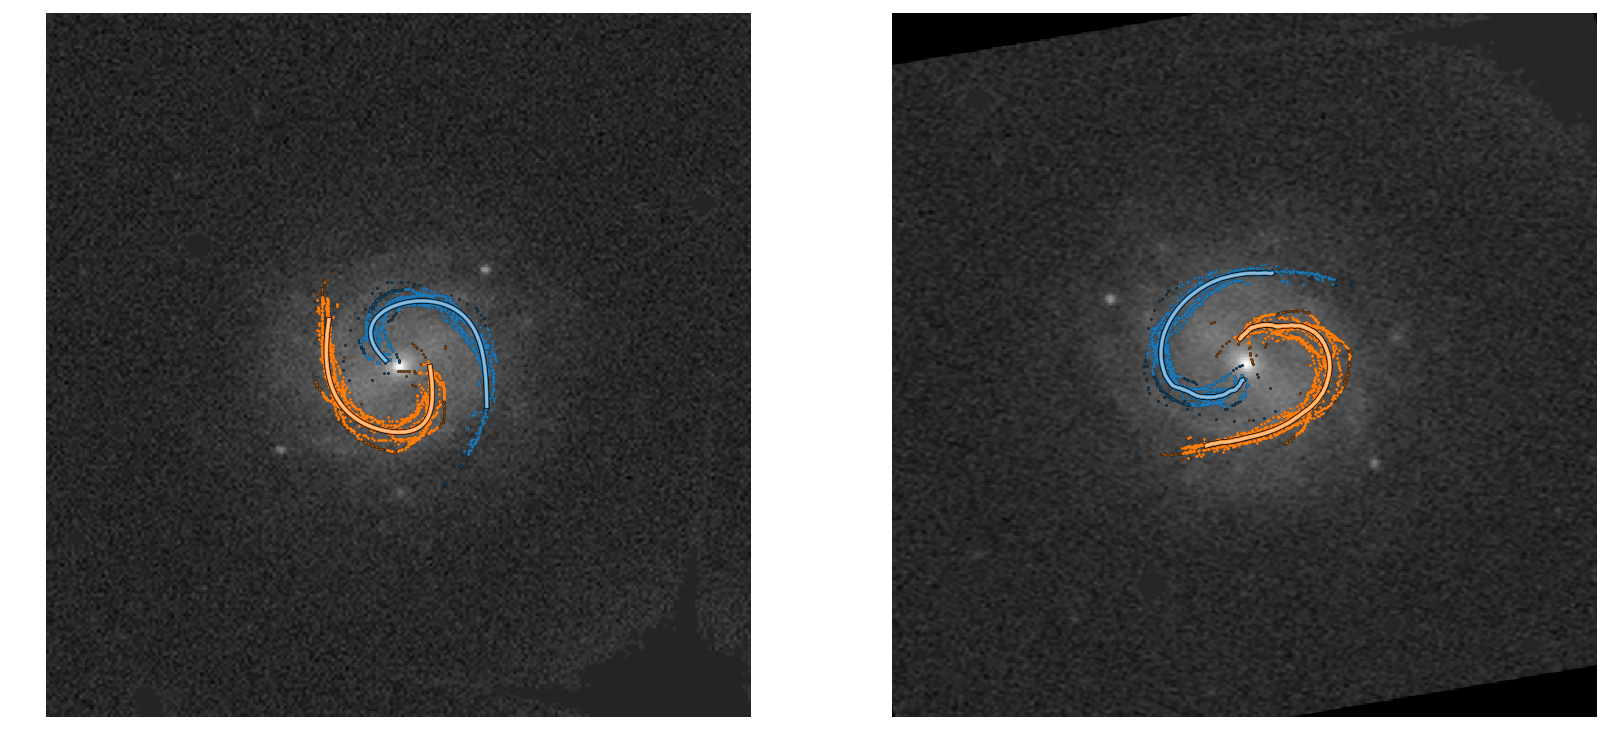

In [143]:
plt.figure(figsize=(20, 10), dpi=100)
plt.subplot(121)
plt.imshow(pic, cmap='gray', origin='lower')
for i, arm in enumerate(s.arms):
    plt.plot(*arm.pointCloud.T, 'k.', markersize=2, alpha=1)
    plt.plot(
        *arm.pointCloud.T,
        '.', c='C{}'.format(i), markersize=2, alpha=0.3
    )
    plt.plot(
        *arm.cleanedCloud.T,
        '.', c='C{}'.format(i), markersize=2, alpha=1
    )

for i, arm in enumerate(xyFits):
    prettyPlot(arm, label='Arm {}'.format(i), c='C{}'.format(i)),

plt.axis('off')

plt.subplot(122)
plt.imshow(deprojectedImage, cmap='gray', origin='lower')
for i, arm in enumerate(result['deprojectedArms']):
    plt.plot(*arm.pointCloud.T, 'k.', markersize=2, alpha=1)
    plt.plot(
        *arm.pointCloud.T,
        '.', c='C{}'.format(i), markersize=2, alpha=0.3
    )
    plt.plot(
        *arm.cleanedCloud.T,
        '.', c='C{}'.format(i), markersize=2, alpha=1
    )
    
for i, arm in enumerate(result['radialFit']):
    prettyPlot(s.arms[i].deNorm(arm), label='Arm {}'.format(i), c='C{}'.format(i)),

plt.axis('off')
None